In [2]:
% matplotlib inline
print("Hello, HW 03!")

Hello, HW 03!


In [64]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.metrics import auc



def prepare_data_notnorm(filename):
    df = pd.read_csv(filename)
    print("shape = {}".format(df.shape))
    objects, labels = df.iloc[:, :-1], df.iloc[:, -1]
    return objects, labels

def get_metriks(Rx: np.ndarray, y: np.ndarray):
    N = y.shape[0]
    TP = np.count_nonzero(np.logical_and(Rx, y)) / N
    FP = np.count_nonzero(np.logical_and(Rx, ~y)) / N
    FN = np.count_nonzero(np.logical_and(~Rx, y)) / N
    TN = np.count_nonzero(~(np.logical_or(Rx, y))) / N

    return TP, FP, TN, FN

In [4]:
# df = pd.read_csv('spambase_old.csv')
obj, labels = prepare_data_notnorm('spambase_old.csv')

shape = (3680, 58)


## Задание 3
Реализуйте алгоритмы построения дерева с критерием информационного выигрыша и
критерием Джини и определению класса по мажоритарному классу в листе. Найдите
оптимальную глубину дерева в обоих случаях (в отрезке 2-10).

In [7]:
df_train = pd.read_csv('spambase_old.csv')
obj_train, labels_train = prepare_data_notnorm('spambase_old.csv')

df_test = pd.read_csv('spambase_new.csv')
obj_test, labels_test = prepare_data_notnorm('spambase_new.csv')

shape = (3680, 58)
shape = (921, 58)


In [8]:
def unique_vals(df: pd.DataFrame, col_name: str):
    """Find the unique values for a column in a dataset."""
    uniq, counts = np.unique(df[col_name], return_counts=True)
    return uniq, counts


def class_counts(df: pd.DataFrame):
    """Counts the number of each type of example in a dataset."""
    uniq, counts = unique_vals(df, 'label')
    # dct = {}
    # for i in range(uniq.shape[0]):
    #     dct[uniq[i]] = counts[i]

    return uniq, counts

In [9]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a column name  and an a value for treshhold. 
    The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question.
    """

    def __init__(self, column_name: str, value: float):
        self.column_name = column_name
        self.value = value

    def match(self, row: pd.DataFrame):
        # Compare the feature value in an example to the
        # feature value in this question.
        # TODO FIX ME FOR WORK FOR THE WHOLE COLUMN
        assert len(row.shape) == 1

        val = row[self.column_name]
        return val >= self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        return "Is \'{}\' >= {}?".format(self.column_name, self.value)

In [10]:
def partition(df: pd.DataFrame, question: Question):
    """Partitions a dataset.
    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """

    true_df = df.loc[df[question.column_name] >= question.value]
    false_df = df.loc[df[question.column_name] < question.value]

    return true_df, false_df


In [13]:
from types import *

def gini(df: pd.DataFrame):
    """Calculate the Gini Impurity for a list of rows.
    2nd metrica for IG
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """

    _, counts = class_counts(df)
    return 1 - ((counts / float(len(df))) ** 2).sum()


def entropy(df: pd.DataFrame):
    """1st metrica for IG"""
    from scipy.stats import entropy
    _, counts = class_counts(df)
    probabilities = counts / len(df)
    return entropy(probabilities)


def info_gain(current_uncertainty: float, parent: pd.DataFrame,
              left: pd.DataFrame, right: pd.DataFrame,
              metrica: FunctionType):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.

    Metrica may be gini impurity or entropy
    """
    assert len(parent) == len(left) + len(right)

    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * metrica(left) - (1 - p) * metrica(right)

In [14]:
def find_best_split(df: pd.DataFrame, metrica: FunctionType,
                    custom_features: np.ndarray = None):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""

    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it

    current_uncertainty = metrica(df)
    
    if custom_features is not None:
        features = custom_features
    else:
        features = list(df)[:-1]

#     print("len of feature = {}".format(len(features)))
    for feature in features:  # for each feature
        uniq_values, count = unique_vals(df, feature)

        for val in uniq_values:  # for each value

            question = Question(feature, val)

            # try splitting the dataset
            true_rows, false_rows = partition(df, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(current_uncertainty, df, true_rows, false_rows,
                             metrica)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [15]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows: pd.DataFrame):
        uniq, counts = class_counts(rows)
        self.uniq = uniq
        self.counts = counts

In [16]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self, question: Question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

## Задание 5
Реализуйте алгоритм Random Forest для любого типа критерия (информационный
выигрыш или Джини) с выбором класса по сумме вероятностей. Постройте Precision-recall
и ROC кривую для полученной вероятности на тестовой выборке

In [180]:
def build_tree_for_forest(rows: pd.DataFrame,
                          metrica: FunctionType,
                          max_depth: int,
                          size_of_feature_sample_for_node: int,
                          all_features: list):
    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    if max_depth == 0:
        return Leaf(rows)

    # get random features
    custom_features = random.sample(all_features, size_of_feature_sample_for_node)

    gain, question = find_best_split(rows, metrica, custom_features)
    new_depth = max_depth - 1

    # Base case: no further info gain
    epsilon = 1e-9
    if gain < epsilon or max_depth == 0:
        return Leaf(rows)  # recursive

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree_for_forest(true_rows, metrica, new_depth,
                                        size_of_feature_sample_for_node,
                                        all_features)

    # Recursively build the false branch.
    false_branch = build_tree_for_forest(false_rows, metrica, new_depth,
                                         size_of_feature_sample_for_node,
                                         all_features)

    # Return a Question node.
    return Decision_Node(question, true_branch, false_branch)

In [182]:
# generate bags and features for BAG_NUMBER tree

BAGS_NUMBER = 32 # Number of trees
bags = []
N = len(df_train)
# print("N = {}".format(N))
all_features = (list(df_train))[:-1] # remove label !
import math

N_FEATURES = int(math.sqrt(len(all_features)) * 1.5) # Number of features for tree
# print("N_FEATURES = {}".format(N_FEATURES))


for i in range(BAGS_NUMBER):
    import random
    ixes = np.random.randint(N, size=(N))
    bags.append(df_train.loc[ixes])


In [184]:
# generate trees for every trainig bag
def random_forest_gen_gini(args):
    import datetime
    (tree_no, max_depth, bag) = args
    print("random_forest_gen_gini{} started at {}".format(tree_no, datetime.datetime.utcnow()))
    tree = build_tree_for_forest(bag, gini, max_depth, N_FEATURES, all_features)
    print("random_forest_gen_gini tree {} done at {}".format(tree_no, datetime.datetime.utcnow()))
    return tree


forest = None
MAX_DEPTH = 10
arguments = [(tree_no, MAX_DEPTH, bags[tree_no]) for tree_no in
             range(len(bags))]
print(len(arguments))
# import random
# random.sample(all_features, k=5)

32


In [185]:
print("Will create {} trees".format(len(arguments)))
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
    forest = p.map(random_forest_gen_gini, arguments)

print("# done")

Will create 32 trees
random_forest_gen_gini0 started at 2018-04-05 20:13:09.539061
random_forest_gen_gini1 started at 2018-04-05 20:13:09.547140
random_forest_gen_gini2 started at 2018-04-05 20:13:09.552210
random_forest_gen_gini3 started at 2018-04-05 20:13:09.558846
random_forest_gen_gini4 started at 2018-04-05 20:13:09.566552
random_forest_gen_gini5 started at 2018-04-05 20:13:09.591056
random_forest_gen_gini6 started at 2018-04-05 20:13:09.605230
random_forest_gen_gini7 started at 2018-04-05 20:13:09.609399
random_forest_gen_gini tree 2 done at 2018-04-05 20:15:16.794804
random_forest_gen_gini8 started at 2018-04-05 20:15:16.854697
random_forest_gen_gini tree 4 done at 2018-04-05 20:15:19.817523
random_forest_gen_gini9 started at 2018-04-05 20:15:19.867003
random_forest_gen_gini tree 7 done at 2018-04-05 20:15:22.807929
random_forest_gen_gini10 started at 2018-04-05 20:15:22.855628
random_forest_gen_gini tree 6 done at 2018-04-05 20:15:25.062641
random_forest_gen_gini11 started at 

In [186]:
def evaluate_forest(df: pd.DataFrame, trees: list) -> np.ndarray:
    def classify_for_forest(row: np.ndarray, node) -> float:
        # Base case: we've reached a leaf
        if isinstance(node, Leaf):
            prob = None
            if len(node.counts) == 1:
                return float(node.uniq[0] == 1)  # 1.0 or 0.0
            elif node.counts[0] >= node.counts[1]:
                total = node.counts.sum()
                prob = node.counts[0] / total
            else:
                total = node.counts.sum()
                prob = node.counts[1] / total
            return prob

        # Decide whether to follow the true-branch or the false-branch.
        # Compare the feature / value stored in the node,
        # to the example we're considering.
        if node.question.match(row):
            return classify_for_forest(row, node.true_branch)
        else:
            return classify_for_forest(row, node.false_branch)

    def function_wrapper(row: np.ndarray) -> float:
        # redo classification
        sum_prob = 0.0
        for tr in trees:
            sum_prob += classify_for_forest(row, tr)
        return sum_prob / len(trees)

    return df.apply(function_wrapper, axis=1)

In [187]:
# *_list - is list of lists of points
def draw_curves(prec_list: list, rec_list: list,
                fpr_list: list, tpr_list: list):
    # plot all
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    for i in range(len(prec_list)):
        plt.plot(rec_list[i], prec_list[i], label="{}".format(i))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    plt.title('ROC curve', fontsize=10)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    for i in range(len(fpr_list)):
        roc_auc = auc(fpr_list[i], tpr_list[i])
        plt.plot(fpr_list[i], tpr_list[i], label="with auc={}".format(roc_auc))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


def gen_data_for_roc(results: np.ndarray, labels: np.ndarray, steps = 100):
    y = labels == 1
    STEPS = steps

    prec_list = []
    rec_list = []
    tpr_list = []
    fpr_list = []

    step = 1.0 / STEPS
    a = 0.0001
    TP = []
    FP = []
    TN = []
    FN = []

    for i in range(STEPS):
        Rx = (results >= a)
        tp, fp, tn, fn = get_metriks(Rx, y)
        TP.append(tp)
        FP.append(fp)
        TN.append(tn)
        FN.append(fn)

        a += step

    TP = np.asarray(TP)
    FP = np.asarray(FP)
    TN = np.asarray(TN)
    FN = np.asarray(FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    tpr = recall
    fpr = FP / (FP + TN)

    prec_list.append(precision)
    rec_list.append(recall)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    
    return prec_list, rec_list, tpr_list, fpr_list

In [190]:
forest_prob_array = evaluate_forest(df_test, forest)

# np.seterr(divide='ignore', invalid='ignore')
precision, recall, tpr_list, fpr_list = gen_data_for_roc(forest_prob_array, df_test['label'], 10000)

Результат для 32 деревьев, максимальная глубина = 10.

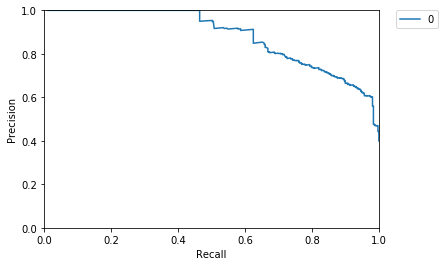

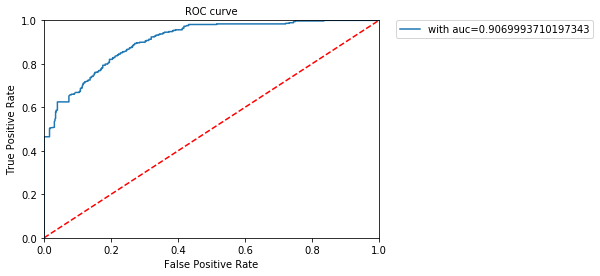

In [191]:
draw_curves(precision, recall, fpr_list, tpr_list)

## Задание 6
Оптимизируйте по AUC на тестовой выборке параметры Random Forest: максимальную
глубину деревьев (в отрезке 2-10), количество деревьев (5, 10, 20, 30, 50, 100, 200, 300). В
этой задаче разумно зафиксировать Random Seed. Постройте Precision-recall и ROC кривую
для лучшего варианта.

Кажется, уже не успеет посчитаться =(